In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
import pickle

In [3]:
data = pd.read_csv('./datas/data_vehicle.csv')


In [4]:
x = data['t'].values
r_in =  data['r_in'].values
vy_in = data['vy_in'].values
c = data['u_in'].values

tck = splrep(x, r_in, s=0.038)
r = splev(x, tck, der=0)
drdt = splev(x, tck, der=1)

tck = splrep(x, vy_in, s=15)
vy = splev(x, tck, der=0)
dvydt = splev(x, tck, der=1)

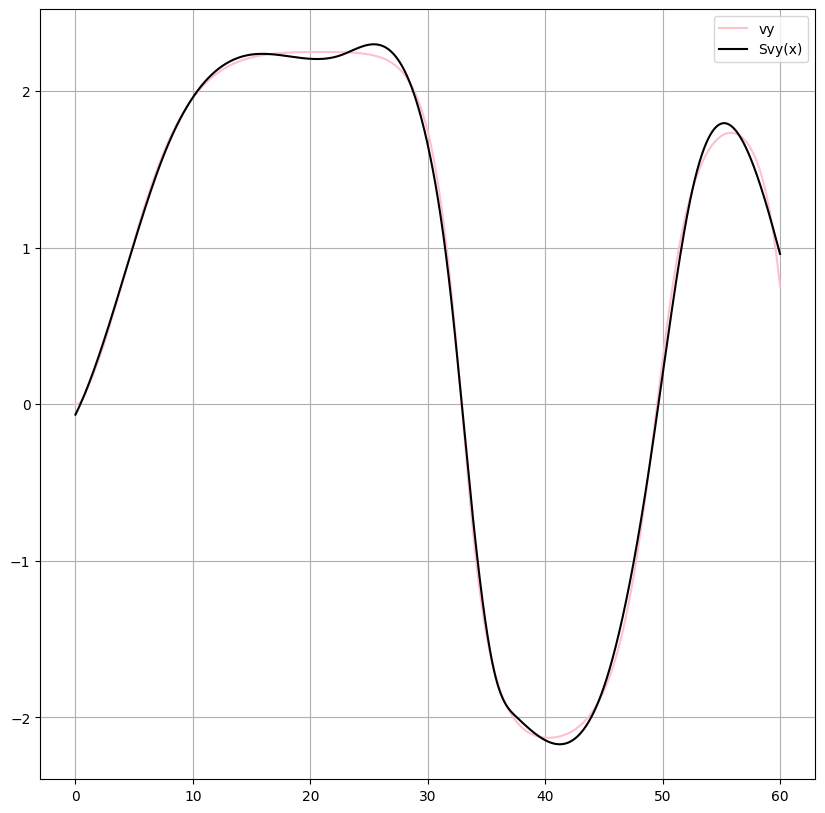

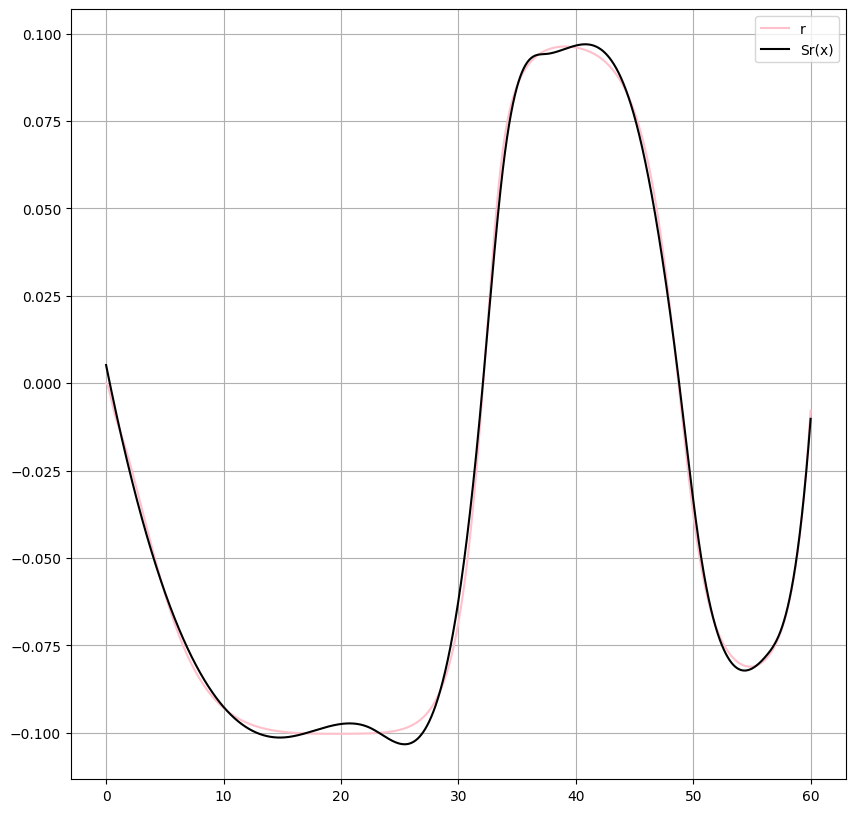

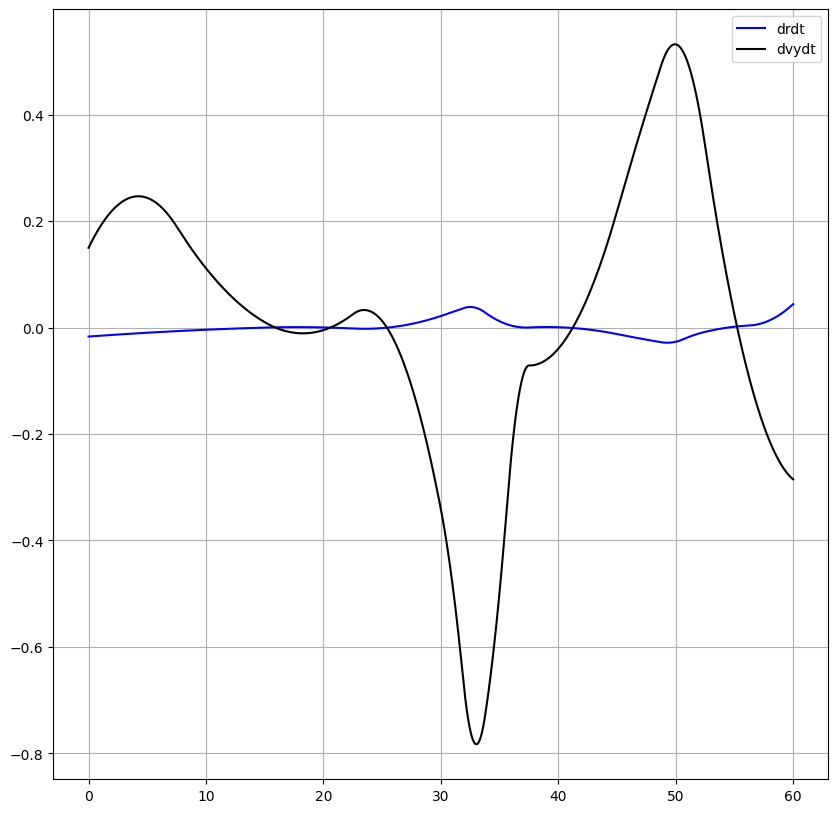

In [5]:
plt.figure(figsize = (10, 10))
plt.plot(data['t'].values, data['vy_in'].values, label="vy", c="pink")
plt.plot(x, vy, '-', label='Svy(x)', c='black')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (10, 10))
plt.plot(data['t'].values, data['r_in'].values, label="r", c="pink")
plt.plot(x, r, '-', label='Sr(x)', c="black")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (10, 10))
plt.plot(x, drdt, '-', label='drdt', c="blue")
plt.plot(x, dvydt, '-', label='dvydt', c="black")
plt.legend()
plt.grid()
plt.show()

In [6]:
# Defintion du système

In [7]:
def f_slip_angle(vy, vx, lf, r, df):
        return ((vy + lf * r) / vx) - df

def r_slip_angle(vy, vx, lr, r):
    return ((vy - lr * r) / vx)

def lateral_pacejka(B, C, D, E, alpha):
    return -1 * D * np.sin(C * np.arctan(B * alpha - E*(B * alpha - np.arctan(B * alpha)))) * 3200

def dynamical_system(vydt, rdt, vy, r, c, vx, m, B, C, D, E, lf, lr, iz):

    iz = iz * 1000

    # slip angles
    af = f_slip_angle(vy, vx, lf, r, c)
    ar = r_slip_angle(vy, vx, lr, r)

    # tire forces
    fyf = lateral_pacejka(B, C, D, E, af)
    fyr = lateral_pacejka(B, C, D, E, ar)

    f0 = vydt - (fyf / m) * np.cos(c) - (fyr / m) + vx * r
    f1 = rdt - (lf / iz) * fyf * np.cos(c) + (lr / iz) * fyr

    return f0, f1

In [8]:
# Fixed parameters :
vx = 30.
m = 1500.

# Parameters :
# B = 3.
# C = 2.
# D = 1.
# E = 1.
# lf = 1.5
# lr = 3.
# iz = 1.9

In [9]:
# ABC - SMC

In [10]:
def sample_from_prior(a, b):
    assert b > a
    return np.random.rand(1) * (b - a) + a

def uniform_proba(x, a, b, dim=1):
    p = 1
    for _ in range(dim):
        if x[_] < a[_] or b[_] < x[_]:
            return 0.
        p *= 1 / (b[_] - a[_])
    return p

def gaussian_proba(x, mu, sigma, dim=1):
    p = 1
    for _ in range(dim):
        p *= (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x[_] - mu[_]) / sigma) ** 2)
    return p

def sample_unif(a,b,dim=1):
    x = np.zeros(dim)
    for _ in range(dim):
        x[_] = sample_from_prior(a[_], b[_])
    return x

nb_iteration_per_population = [100000, 100000, 100000, 100000, 100000, 100000, 100000] # [100000, 100000, 100000, 100000, 500000]

params = ['B', 'C', 'D', 'E', 'lf', 'lr', 'iz']

prior = np.asarray([
    [2.20, 3.8], 
    [1.2, 2.8],
    [0.2, 1.8],
    [0.2, 1.8],
    [0.7, 2.3],
    [2.2, 3.8],
    [1.1, 2.7]
    ])
prior = prior + 0.2
percentil = [0.001, 0.00, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
std = 0.05

populations = []
criterions = []

for pop_idx, iter in enumerate(nb_iteration_per_population):

    normalization_factor = np.zeros(iter)
    prior_probs = np.zeros(iter)
    samples = np.zeros((iter, len(params)))
    criterion = np.zeros(iter)

    ctr = 0

    for i in range(10000000):

        if pop_idx == 0:

            # Sample from prior
            s = sample_unif(prior[:,0], prior[:,1], dim=len(params))

            # Generate from dynamical system :
            B = s[0]
            C = s[1]
            D = s[2]
            E = s[3]
            lf = s[4]
            lr = s[5]
            iz = s[6]

            f0, f1 = dynamical_system(dvydt, drdt, vy, r, c, vx, m, B, C, D, E, lf, lr, iz)

            crit = np.mean(np.sqrt(f0**2)) + np.mean(np.sqrt(f1**2))

            criterion[ctr] = crit
            samples[ctr] = s

            # Increase counter
            ctr += 1

        # Sample from previous population
        elif pop_idx > 0:
            
            # Select individual and compute pertubation
            sampling_idx = np.random.choice(np.arange(percentil_idx), size=1, replace=True, p=weights_prev)[0]
            s = np.random.normal(samples_prev[sampling_idx], std)

            # Compute prior prob
            prior_probs[ctr] = uniform_proba(s, prior[:,0], prior[:,1], dim=len(params))

            if prior_probs[ctr] != 0:

                # Compute normalization factor
                normalization_factor[ctr] = np.sum([weights_prev[j] * gaussian_proba(s, samples_prev[j], std, dim=len(params)) for j in range(percentil_idx)])

                # Generate from dynamical system :
                B = s[0]
                C = s[1]
                D = s[2]
                E = s[3]
                lf = s[4]
                lr = s[5]
                iz = s[6]

                f0, f1 = dynamical_system(dvydt, drdt, vy, r, c, vx, m, B, C, D, E, lf, lr, iz)

                crit = np.mean(np.sqrt(f0**2)) + np.mean(np.sqrt(f1**2))

                criterion[ctr] = crit
                samples[ctr] = s

                # Increase counter
                ctr += 1
            
        if ctr % 1000 == 0:
            print((ctr / iter) * 100)
        if ctr == iter:
            break

    # Set population
    sorted_idx = np.argsort(criterion)
    percentil_idx = int(iter * percentil[pop_idx])
    sorted_criterion = criterion[sorted_idx]
    
    sorted_samples = samples[sorted_idx]
    sorted_prior_prob = prior_probs[sorted_idx]
    sorted_normalization_factor = normalization_factor[sorted_idx]

    samples_prev = sorted_samples[:percentil_idx].copy()

    populations.append(samples_prev)
    criterions.append(sorted_criterion[:percentil_idx])
    
    # Compute weights
    weights = np.ones(percentil_idx)
    if pop_idx > 0:
        for i in range(percentil_idx):
            weights[i] = sorted_prior_prob[i] / sorted_normalization_factor[i]

    # Copy previous weights
    weights_prev = weights.copy()

    # Normalize weights
    weights_prev /= np.sum(weights_prev)

# Save the object to a file
file = open('particle_.pkl', 'wb')
pickle.dump(populations, file)
file.close()

1.0
2.0
3.0
4.0


KeyboardInterrupt: 

In [11]:
# Load the object from the file
file = open('particle.pkl', 'rb')
populations = pickle.load(file)
file.close()

variables = ['B', 'C', 'D', 'E', 'lf', 'lr', 'iz']

In [12]:
B = populations[-1][:, 0]
C = populations[-1][:, 1]
D = populations[-1][:, 2]
E = populations[-1][:, 3]
lf = populations[-1][:, 4]
lr = populations[-1][:, 5]
iz = populations[-1][:, 6]
X = np.asarray([B, C, D, E, lf, lr, iz])


In [13]:
print(f"max {B[0]} {C[0]} {D[0]} {E[0]} {lf[0]} {lr[0]} {iz[0]}")
print(f"mean {B.mean()} {C.mean()} {D.mean()} {E.mean()} {lf.mean()} {lr.mean()} {iz.mean()}")
print(f"mean {B.std()} {C.std()} {D.std()} {E.std()} {lf.std()} {lr.std()} {iz.std()}")

max 2.961156914305494 1.723137989628586 1.1769664953333645 1.6859697281917987 1.5071295956794093 3.009754754117294 1.7983081294385994
mean 3.062999340959241 1.8529129446177985 1.0836400119712093 1.2502480572201018 1.417966743803622 2.8514801726064114 2.3591909891957648
mean 0.34849588681791516 0.2913831642464521 0.09552994005100227 0.4275105607425322 0.15380513145241148 0.2698828380290569 0.3278112342617027


In [22]:
from tqdm import tqdm
X = np.asarray([B, C, D, E, lf, lr, iz])
X = X.T
variables = ["B" ,"C", "D", "E", "lf", "lr", "Iz"]

critss = []

index_list = np.arange(0,len(B))
validation_ratio = 0.5

# Génération des index d'entraînement et de validation
train_indexes, val_indexes = train_test_split(index_list, test_size=validation_ratio, random_state=42)

bandwidths = np.arange(0.025, 1, 0.01)

for i, bandwidth in tqdm(enumerate(bandwidths)):

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X[train_indexes]) # epanechnikov gaussian tophat
    kde_score = kde.score_samples(X[val_indexes])
   
    critss.append(np.sum(kde_score))

best_bandwidth = bandwidths[np.argmax(critss)]

print(best_bandwidth)

98it [00:06, 15.67it/s]

0.065


MAP particule

In [23]:
B_ABC_SMC = B[:1]
C_ABC_SMC = C[:1]
D_ABC_SMC = D[:1]
E_ABC_SMC = E[:1]
lf_ABC_SMC = lf[:1]
lr_ABC_SMC = lr[:1]
iz_ABC_SMC = iz[:1]

print(f"max {B_ABC_SMC[0]} {C_ABC_SMC[0]} {D_ABC_SMC[0]} {E_ABC_SMC[0]} {lf_ABC_SMC[0]} {lr_ABC_SMC[0]} {iz_ABC_SMC[0]}")
print(f"mean max {B_ABC_SMC.mean()} {C_ABC_SMC.mean()} {D_ABC_SMC.mean()} {E_ABC_SMC.mean()} {lf_ABC_SMC.mean()} {lr_ABC_SMC.mean()} {iz_ABC_SMC.mean()}")

max 2.961156914305494 1.723137989628586 1.1769664953333645 1.6859697281917987 1.5071295956794093 3.009754754117294 1.7983081294385994
mean max 2.961156914305494 1.723137989628586 1.1769664953333645 1.6859697281917987 1.5071295956794093 3.009754754117294 1.7983081294385994


Sampling from KDE

In [24]:
kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth).fit(X)

samples = kde.sample(500000)
kde_score = kde.score_samples(samples)

B_KDE = samples[np.argsort(kde_score)[-5:], 0]
C_KDE = samples[np.argsort(kde_score)[-5:], 1]
D_KDE = samples[np.argsort(kde_score)[-5:], 2]
E_KDE = samples[np.argsort(kde_score)[-5:], 3]
lf_KDE = samples[np.argsort(kde_score)[-5:], 4]
lr_KDE = samples[np.argsort(kde_score)[-5:], 5]
iz_KDE = samples[np.argsort(kde_score)[-5:], 6]

In [25]:
print(f"max {B_KDE[-1:]} {C_KDE[-1:]} {D_KDE[-1:]} {E_KDE[-1:]} {lf_KDE[-1:]} {lr_KDE[-1:]} {iz_KDE[-1:]}")
print(f"mean max {B_KDE.mean()} {C_KDE.mean()} {D_KDE.mean()} {E_KDE.mean()} {lf_KDE.mean()} {lr_KDE.mean()} {iz_KDE.mean()}")

max [3.10734732] [1.78957955] [1.08651457] [1.17492667] [1.36973224] [2.76051031] [2.64600434]
mean max 3.2082939229558582 1.7442252701935648 1.0889030952418584 1.1710009285730538 1.3533303918863138 2.7512381686430314 2.5087566648699484


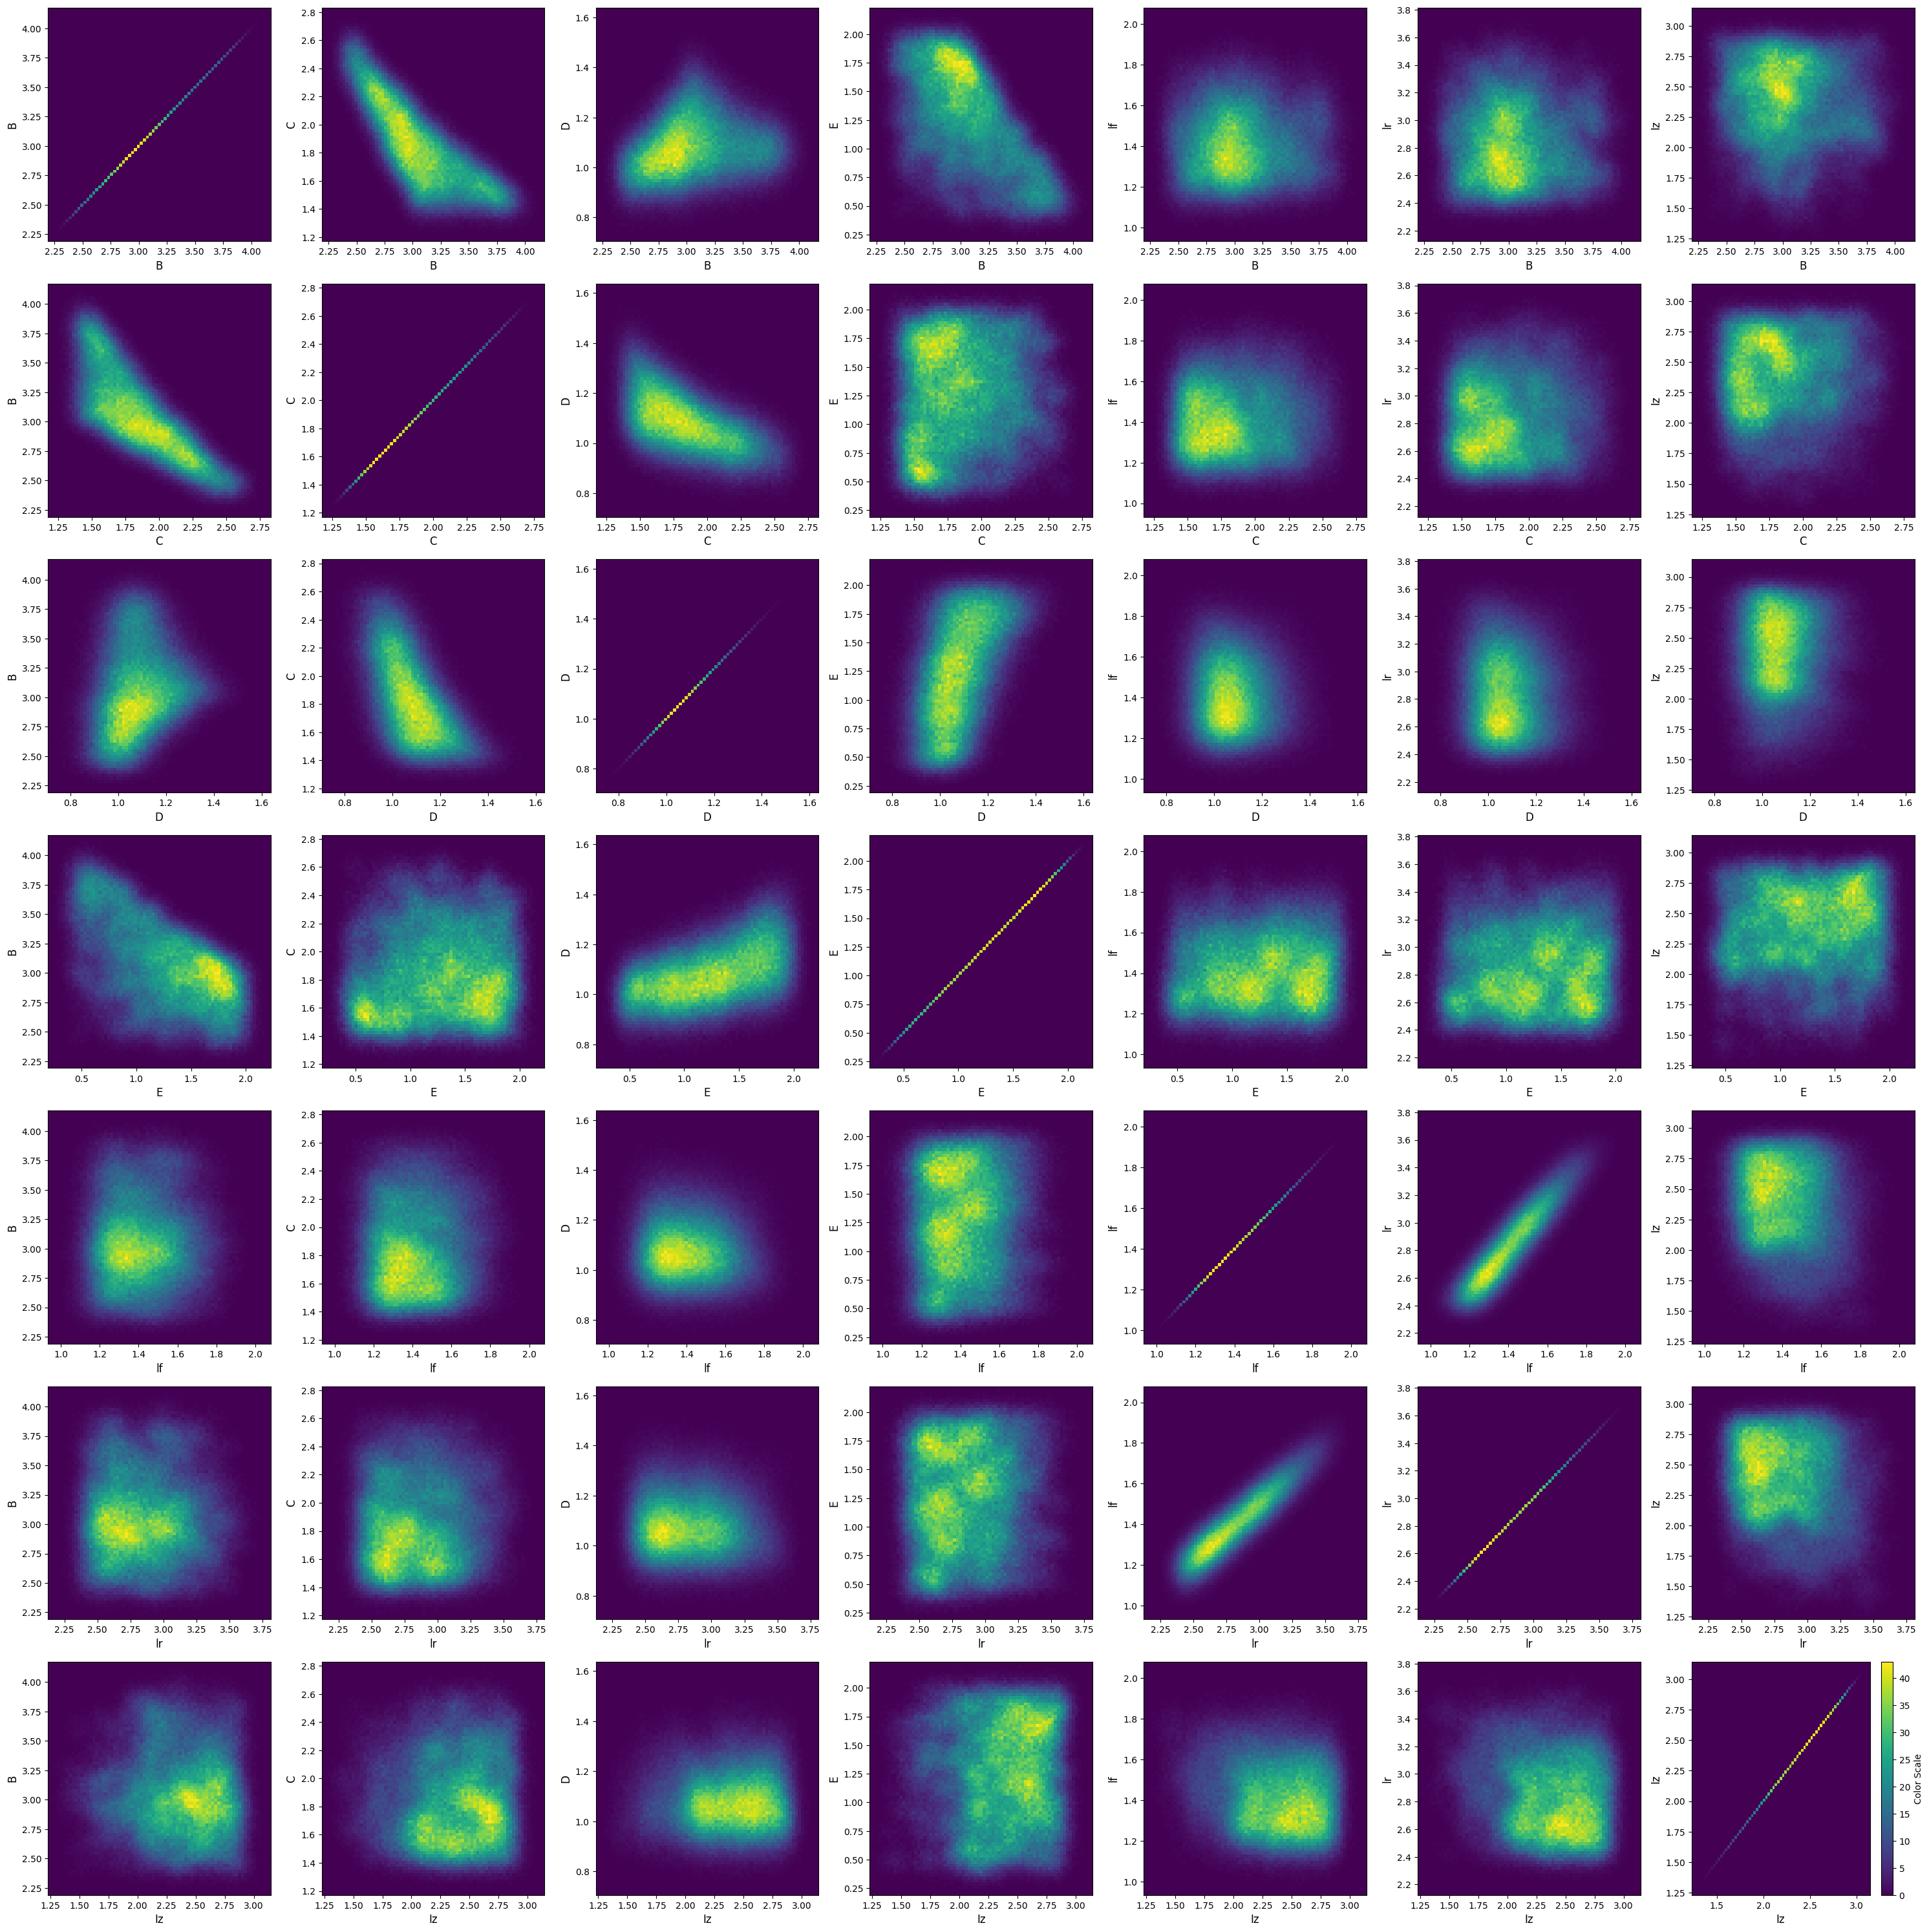

In [26]:
# Create the figure and axes
fig, axes = plt.subplots(len(variables), len(variables), figsize=(30, 30))

# Plot histograms and scatter plots
for i in range(len(variables)):
    for j in range(len(variables)):
        # axes[i, j].hist2d(data[:, i], data[:, j], bins=100)
        # axes[i, j].scatter(data[:1, i], data[:1, j], c="black", s=2)
        # axes[i, j].set_xlabel(params[i])
        # axes[i, j].set_ylabel(params[j])

        axes[i,j].hist2d(samples[:,i], samples[:,j], bins = 75, density=True)
        # axes[i,j].scatter(X[:1, i], X[:1, j], c="black", s=2) 
        axes[i,j].set_xlabel(variables[i], fontsize=12)
        axes[i,j].set_ylabel(variables[j], fontsize=12)

# Add a color scale to the last axis
last_ax = axes[len(variables)-1, len(variables)-1]
cbar = plt.colorbar(last_ax.collections[0], ax=last_ax)
cbar.set_label('Color Scale')

# Adjust the layout
plt.tight_layout()
plt.savefig("test.svg", format="svg")
# Display the plot
plt.show()

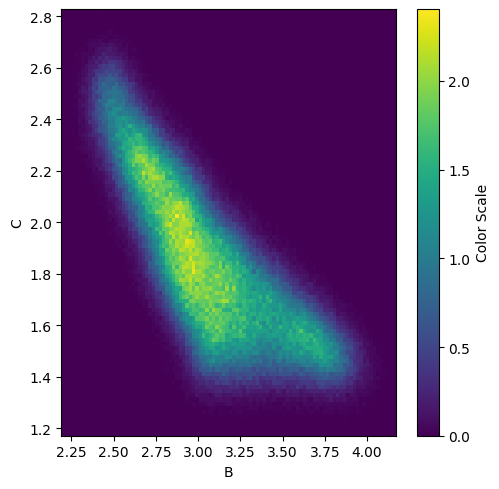

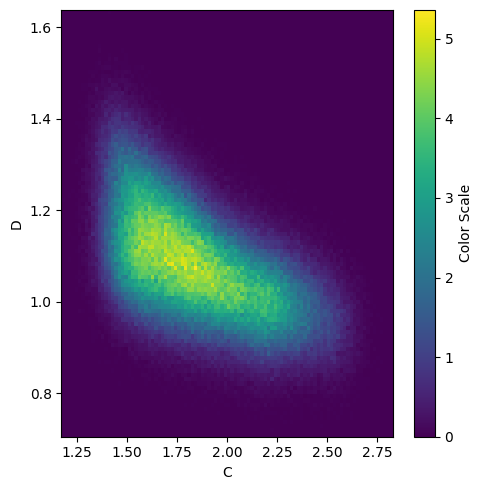

NameError: name 'priorvariables' is not defined

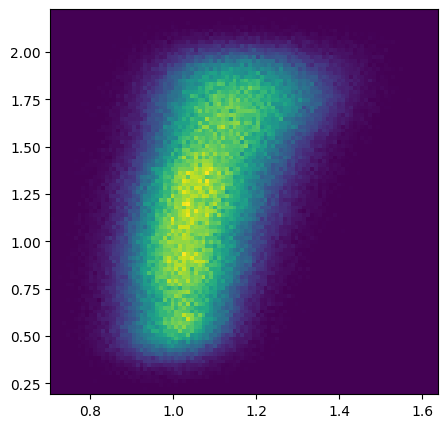

In [27]:
plot_idx = [0, 1, 2, 5, 7]

plt.figure(figsize=(5, 5))
plt.hist2d(samples[:, 0], samples[:, 1], bins=100, density=True)
plt.xlabel(variables[0])
plt.ylabel(variables[1])
plt.tight_layout()
cbar = plt.colorbar()
cbar.set_label('Color Scale')
plt.show()

plt.figure(figsize = (5, 5))
plt.hist2d(samples[:,1], samples[:,2], bins = 100, density=True)
plt.xlabel(variables[1])
plt.ylabel(variables[2])
plt.tight_layout()
cbar = plt.colorbar()
cbar.set_label('Color Scale')
plt.show()

plt.figure(figsize = (5, 5))
plt.hist2d(samples[:,2], samples[:,3], bins = 100, density=True)
plt.xlabel(priorvariables[2])
plt.ylabel(variables[3])
plt.tight_layout()
cbar = plt.colorbar()
cbar.set_label('Color Scale')
plt.show()

plt.figure(figsize = (5, 5))
plt.hist2d(samples[:,4], samples[:,5], bins = 100, density=True)
plt.xlabel(variables[4])
plt.ylabel(variables[5])
plt.tight_layout()
cbar = plt.colorbar()
cbar.set_label('Color Scale')
plt.show()


In [28]:
# Population evolution

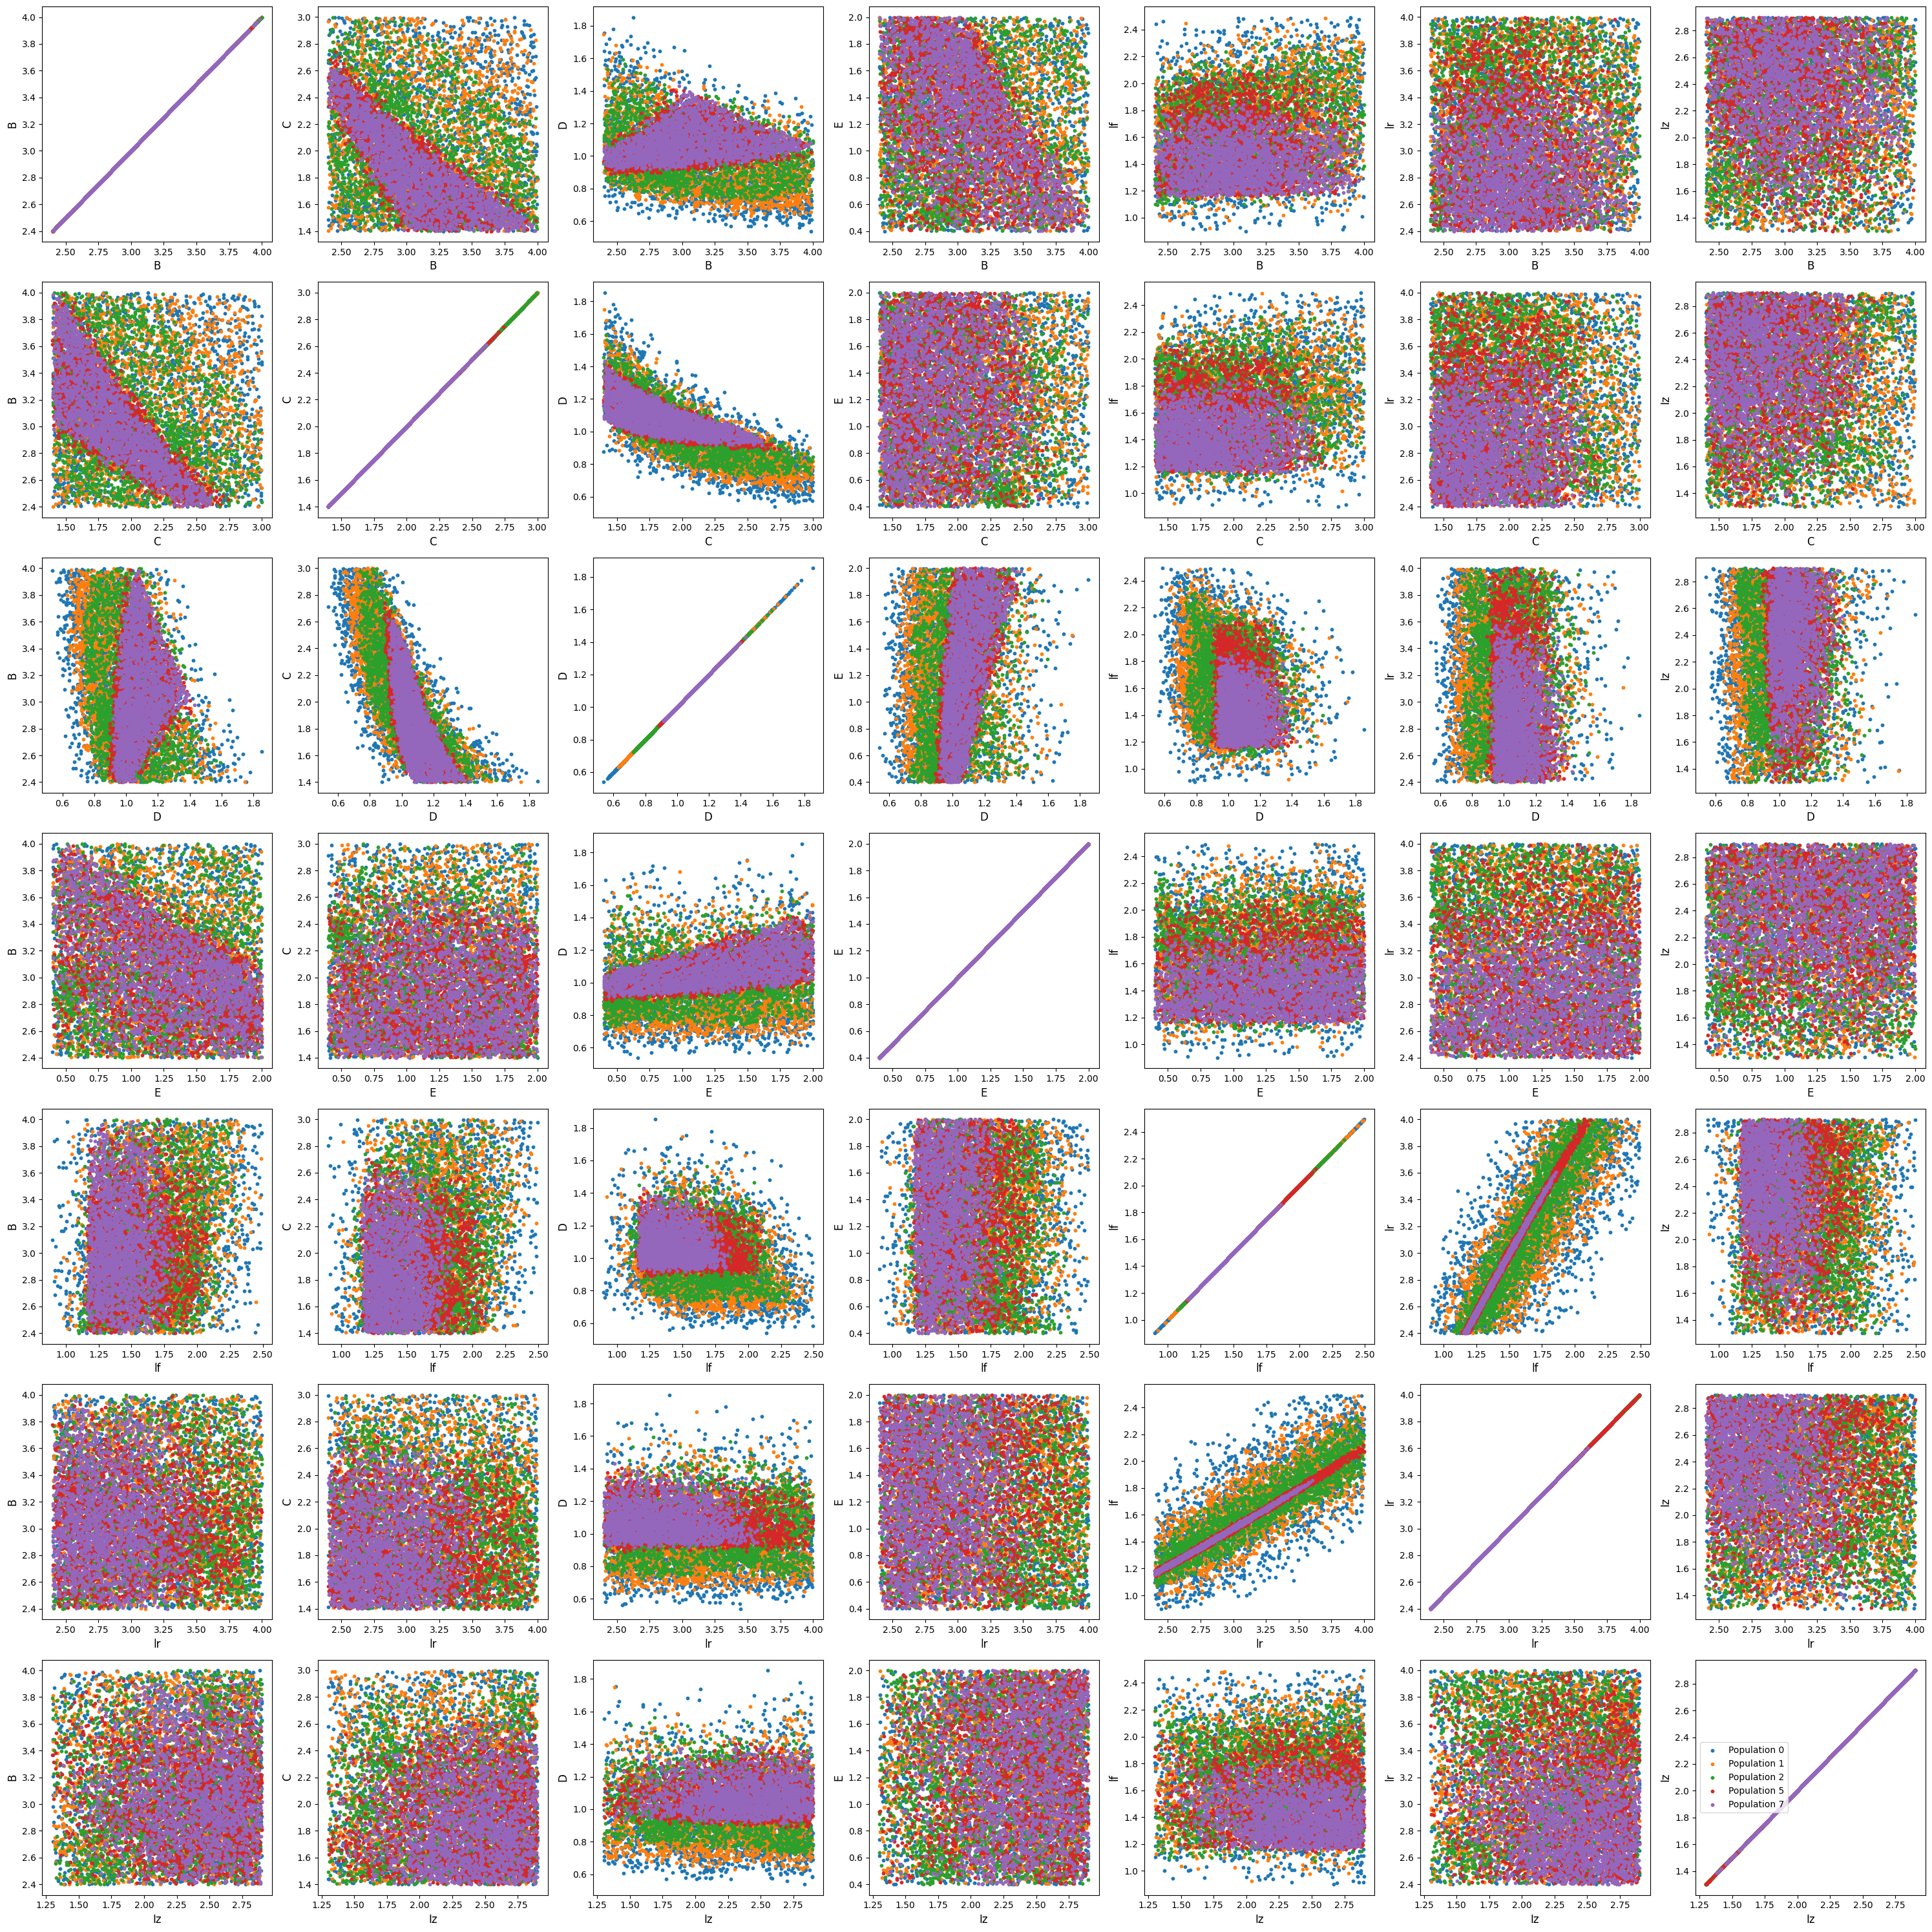

In [29]:
params = variables
plot_idx = [0, 1, 2, 5, 7]
fig, axes = plt.subplots(len(params), len(params), figsize = (30, 30))
for i in range(len(params)):
    for j in range(len(params)):
        for p in range(len(plot_idx)):
            axes[i,j].scatter(populations[plot_idx[p]][:,i], populations[plot_idx[p]][:,j], marker='o', label=f"Population {plot_idx[p]}", s=10) 
        axes[i,j].set_xlabel(params[i], fontsize=12)
        axes[i,j].set_ylabel(params[j], fontsize=12)
        # axes[i,j].scatter(X[:1, i], X[:1, j], c="black", s=10)

plt.tight_layout()
plt.legend(loc='center left')
plt.show()

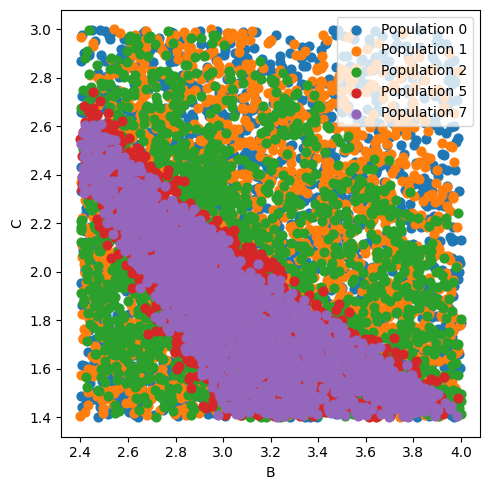

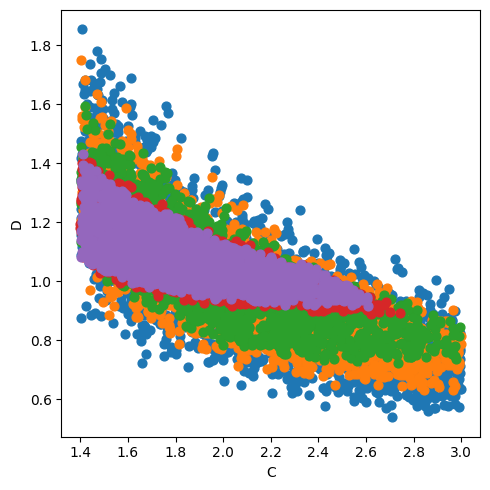

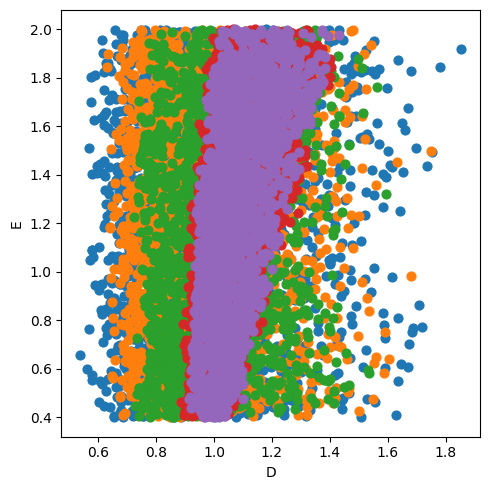

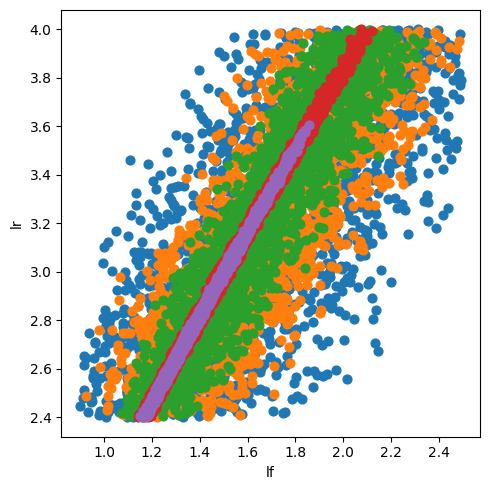

In [30]:
plot_idx = [0, 1, 2, 5, 7]

plt.figure(figsize = (5, 5))
for p in range(len(plot_idx)):
    plt.scatter(populations[plot_idx[p]][:,0], populations[plot_idx[p]][:,1], marker='o', label=f"Population {plot_idx[p]}", s=40) 
plt.xlabel(variables[0])
plt.ylabel(variables[1])
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
for p in range(len(plot_idx)):
    plt.scatter(populations[plot_idx[p]][:,1], populations[plot_idx[p]][:,2], marker='o', label=f"Population {plot_idx[p]}", s=40)
plt.xlabel(variables[1])
plt.ylabel(variables[2])
plt.tight_layout()
plt.show()

plt.figure(figsize = (5, 5))
for p in range(len(plot_idx)):
    plt.scatter(populations[plot_idx[p]][:,2], populations[plot_idx[p]][:,3], marker='o', label=f"Population {plot_idx[p]}", s=40)
plt.xlabel(variables[2])
plt.ylabel(variables[3])
plt.tight_layout()
plt.show()

plt.figure(figsize = (5, 5))
for p in range(len(plot_idx)):
    plt.scatter(populations[plot_idx[p]][:,4], populations[plot_idx[p]][:,5], marker='o', label=f"Population {plot_idx[p]}", s=40)
plt.xlabel(variables[4])
plt.ylabel(variables[5])
plt.tight_layout()
plt.show()


In [31]:
from scipy.integrate import odeint

In [32]:
# Tracé des evolutions :

In [36]:
def f_slip_angle(vy, vx, lf, r, df):
    return ((vy + lf * r) / vx) - df

def r_slip_angle(vy, vx, lr, r):
    return ((vy - lr * r) / vx)

def lateral_pacejka(alpha, B = 3, C = 2, D = 1, E= 1):
    return -D * np.sin(C * np.arctan(B * alpha - E*(B *alpha - np.arctan(B * alpha)))) * 3200

def vehicle_system(y, t, lf, lr, m, vx, iz, B, C, D, E):

    # system state
    vy = y[0]
    r = y[1]
    xg = y[2]
    yg = y[3]
    theta = y[4]

    # control input
    df = cs(t)

    # slip angles
    af = f_slip_angle(vy, vx, lf, r, df)
    ar = r_slip_angle(vy, vx, lr, r)

    fyf = lateral_pacejka(af, B, C, D, E) 
    fyr = lateral_pacejka(ar, B, C, D, E)

    # system state derivative
    vydt = (fyf / m) * np.cos(df) + (fyr / m) - vx * r 
    rdt = (lf / iz) * fyf * np.cos(df) - (lr / iz) * fyr

    xgdt = vx * np.cos(theta) - vy * np.sin(theta)
    ygdt = vx * np.sin(theta) + vy * np.cos(theta)
    thetadt = r

    dydt = np.asarray([vydt, rdt, xgdt, ygdt, thetadt])

    return dydt

4.366670268274746e-08
5.782926805665892e-09


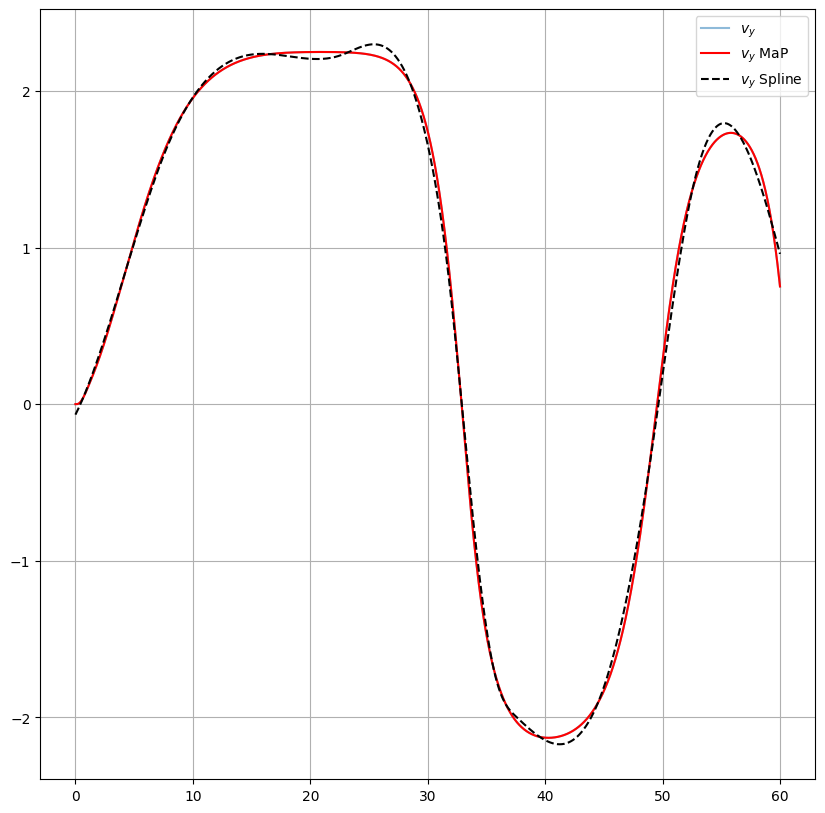

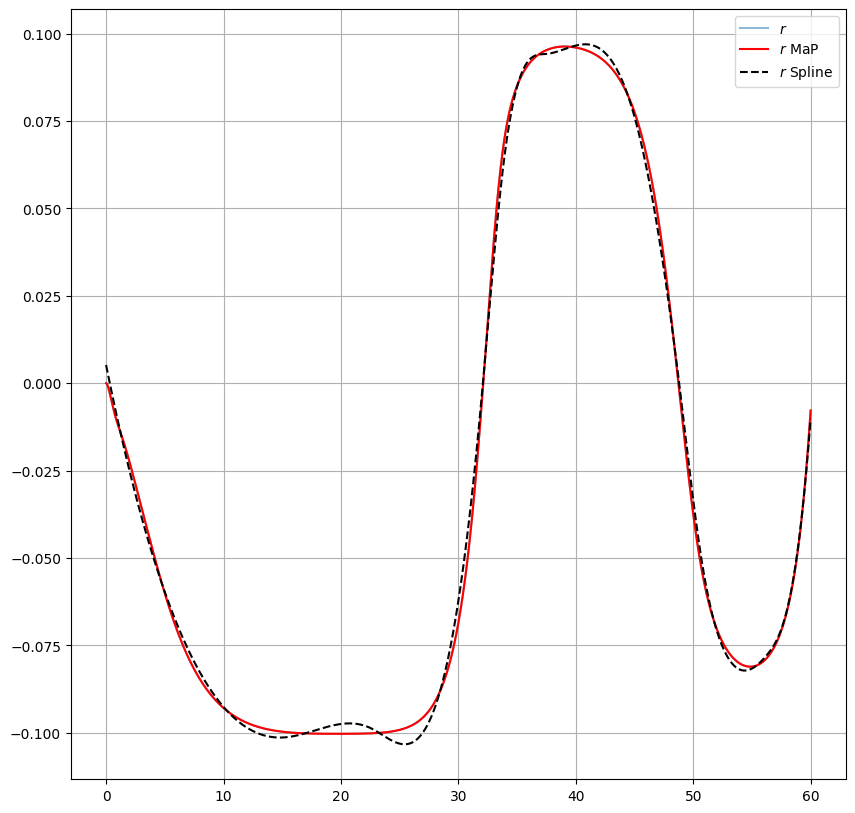

In [37]:
from scipy.interpolate import CubicSpline
y0 = np.asarray([
        0., # vy
        0.,  # r
        10., # xg
        10., # yg
        0., # ta
        ])

cs = CubicSpline(x, c)


sol = odeint(vehicle_system, y0, x, args=(
    1.5, 
    3., 
    m, 
    vx, 
    1900, 
    3.,
    2., 
    1., 
    1.
    ))

RMSE_vy = np.mean(np.sqrt((sol[:, 0] - vy_in)**2))
RMSE_r = np.mean(np.sqrt((sol[:, 1] - r_in)**2))
print(RMSE_vy)
print(RMSE_r)

plt.figure(figsize=(10, 10))
plt.plot(x, vy_in, alpha=0.5, label="$v_y$")
plt.plot(x, sol[:, 0], color='red', alpha=1, label="$v_y$ MaP")
plt.plot(x, vy, linestyle='dashed', color='black', alpha=1, label="$v_y$ Spline")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(x, r_in, alpha=0.5, label="$r$")
plt.plot(x, sol[:, 1], color='red', alpha=1, label="$r$ MaP")
plt.plot(x, r, linestyle='dashed', color='black', alpha=1, label="$r$ Spline")
plt.grid(True)
plt.legend()
plt.show()